In [ ]:
import sys
sys.path
sys.path.append('/volatile/aurelien_stumpf_mascles/project/code/')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from torch.utils.data.sampler import BatchSampler
import package

## Fonctions utiles

In [ ]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

In [ ]:
@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

## Data loading and preprocessing

In [ ]:
loaded_arrays = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/SYNTHETIC_database/sub-200_states-4_noise-high_synth/dataset.npz')
print(loaded_arrays.files)

['data25', 'dfc25', 'labels25', 'data30', 'dfc30', 'labels30', 'data35', 'dfc35', 'labels35', 'data40', 'dfc40', 'labels40', 'data45', 'dfc45', 'labels45', 'states']


In [ ]:
dfc45 = torch.from_numpy(loaded_arrays['dfc45'])
labels45 = loaded_arrays["labels45"]
data45 = loaded_arrays['data45']

In [ ]:
# create labels for dfcs
labels_with_transition = package.preprocessing.create_labels_with_transitions(labels45)

In [9]:
# extract the flattened higher triangular
fc_train = package.preprocessing.flatten_higher_triangular(dfc45)
fc_train = fc_train[0:10,:,:]
print(fc_train.shape)

(10, 455, 3321)


In [10]:
# generate the distance matrix of the dataset
distance = torch.from_numpy(package.preprocessing.generate_vector_distance(fc_train,distance="euclidean"))

0
1
2
3
4
5
6
7
8
9


In [12]:
plt.hist(distance.flatten(),bins=100)

## Cebra model training

In [15]:
#We define the architecture of the model we will use

num_output = 3
normalize = True
num_neurons = 3321

model = cebra2.model.Model(
    nn.Linear(
        num_neurons,
        num_output * 1000,
    ),
    nn.GELU(),
    nn.Linear(int(num_output * 1000), num_output * 200),
    nn.GELU(),
    nn.Linear(int(num_output * 200), num_output * 60),
    nn.GELU(),
    nn.Linear(int(num_output * 60), num_output * 30),
    nn.GELU(),
    nn.Linear(int(num_output * 30), num_output),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

In [16]:
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 2048,  distance = distance, time_delta = 20, matrix_delta = 4)

NameError: name 'distance' is not defined

In [ ]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

In [31]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 3.3123, Train accuracy 0.00%
Epoch 100
Train loss 3.2452, Train accuracy 0.00%
Epoch 200
Train loss 3.2384, Train accuracy 0.00%
Epoch 300
Train loss 3.2401, Train accuracy 0.00%
Epoch 400
Train loss 3.2380, Train accuracy 0.00%


KeyboardInterrupt: 

### Plot the results

In [23]:
a,b,c = fc_dataset.neural.shape
data_print = fc_dataset.neural.reshape(a*b,c)
labels_print = labels_with_transition[0:10,:].reshape(a*b)
fc_emb = _compute_emissions_single(cebra_fc, data_print)
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple']
ax1.scatter(fc_emb[:,0], fc_emb[:,1], cmap = matplotlib.colors.ListedColormap(colors), c = labels_print, s=1)
#ax1.xticks() 
ax1.axis('on')

NameError: name 'cebra_fc' is not defined

### Comparaison des matrices de connectivité moyennes avec les true labels

In [97]:
states = torch.from_numpy(loaded_arrays['states'])
states_preprocessed = torch.from_numpy(package.preprocessing.flatten_higher_triangular(states)).type(torch.float32)
states_emb = _compute_emissions_single(cebra_fc, states_preprocessed)

(-1.06568386554718, 1.0790733337402343, -0.990953129529953, 1.0889645040035247)

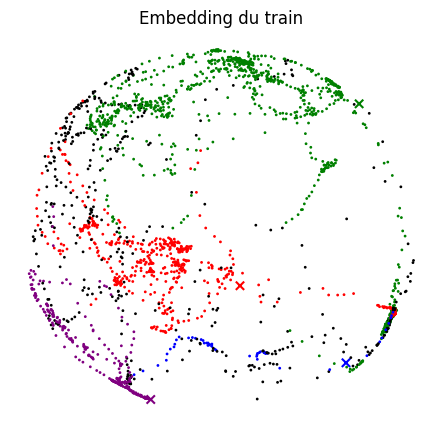

In [99]:
fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ['black','red','green','blue','purple']
ax1.scatter(states_emb[:,1], states_emb[:,2], cmap = matplotlib.colors.ListedColormap(colors[1:]), c = [1,2,3,4], marker = "x")
ax1.scatter(fc_emb[:,1], fc_emb[:,2], cmap = matplotlib.colors.ListedColormap(colors), c = labels_print, s=1)
ax1.axis('off')

## Entraînement d'un classifieur sur l'espace latent

In [107]:
net = package.torch_classifier.MLP(input_dim = 3)
X = fc_emb[labels_print > 0]
y = labels_print[labels_print > 0]
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train = package.torch_classifier.SimpleDataset(X_train,y_train)
test = package.torch_classifier.SimpleDataset(X_test,y_test)
train_loader = torch.utils.data.DataLoader(train, batch_size=1000, shuffle=True, num_workers=6)
test_loader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=True, num_workers=6)

In [109]:
package.torch_classifier.Train(net,train_loader,test_loader,100)

Train loss 0.0014, Train accuracy 20.40%
End of testing. Test accuracy 18.00%
Train loss 0.0013, Train accuracy 20.50%
End of testing. Test accuracy 19.90%
Train loss 0.0012, Train accuracy 20.50%
End of testing. Test accuracy 19.90%
Train loss 0.0011, Train accuracy 29.45%
End of testing. Test accuracy 32.90%
Train loss 0.0008, Train accuracy 46.75%
End of testing. Test accuracy 43.50%
Train loss 0.0006, Train accuracy 46.80%
End of testing. Test accuracy 43.40%
Train loss 0.0005, Train accuracy 46.10%
End of testing. Test accuracy 42.50%
Train loss 0.0005, Train accuracy 45.50%
End of testing. Test accuracy 42.30%
Train loss 0.0005, Train accuracy 45.45%
End of testing. Test accuracy 42.30%
Train loss 0.0005, Train accuracy 45.15%
End of testing. Test accuracy 43.20%
End of training.

